## ALE plots

In [1]:
import sys
sys.path

['C:\\D_Drive\\Indra\\github_projects\\explainability\\PyALE-master\\decoding',
 'C:\\Users\\iammo\\anaconda3\\envs\\demo01\\python311.zip',
 'C:\\Users\\iammo\\anaconda3\\envs\\demo01\\DLLs',
 'C:\\Users\\iammo\\anaconda3\\envs\\demo01\\Lib',
 'C:\\Users\\iammo\\anaconda3\\envs\\demo01',
 '',
 'C:\\Users\\iammo\\anaconda3\\envs\\demo01\\Lib\\site-packages',
 'C:\\Users\\iammo\\anaconda3\\envs\\demo01\\Lib\\site-packages\\win32',
 'C:\\Users\\iammo\\anaconda3\\envs\\demo01\\Lib\\site-packages\\win32\\lib',
 'C:\\Users\\iammo\\anaconda3\\envs\\demo01\\Lib\\site-packages\\Pythonwin']

In [2]:
alepath="C:\D_Drive\Indra\github_projects\explainability\PyALE-master"
sys.path.insert(0,alepath)
sys.path

['C:\\D_Drive\\Indra\\github_projects\\explainability\\PyALE-master',
 'C:\\D_Drive\\Indra\\github_projects\\explainability\\PyALE-master\\decoding',
 'C:\\Users\\iammo\\anaconda3\\envs\\demo01\\python311.zip',
 'C:\\Users\\iammo\\anaconda3\\envs\\demo01\\DLLs',
 'C:\\Users\\iammo\\anaconda3\\envs\\demo01\\Lib',
 'C:\\Users\\iammo\\anaconda3\\envs\\demo01',
 '',
 'C:\\Users\\iammo\\anaconda3\\envs\\demo01\\Lib\\site-packages',
 'C:\\Users\\iammo\\anaconda3\\envs\\demo01\\Lib\\site-packages\\win32',
 'C:\\Users\\iammo\\anaconda3\\envs\\demo01\\Lib\\site-packages\\win32\\lib',
 'C:\\Users\\iammo\\anaconda3\\envs\\demo01\\Lib\\site-packages\\Pythonwin']

In [3]:
from PyALE import ale, ALE_1D, ALE_2D, lib

In [4]:
ALE_1D.fn_check()

2024-04-17 15:08:58.433 | INFO     | PyALE._src.ALE_1D:fn_check:19 - This line will not come if logger.disable is done in the start of the file
2024-04-17 15:08:58.436 | INFO     | PyALE._src.ALE_1D:fn_check:22 - In the fn_check method
2024-04-17 15:08:58.438 | DEBUG    | PyALE._src.ALE_1D:fn_check:24 - A debug message.
2024-04-17 15:08:58.439 | INFO     | PyALE._src.ALE_1D:fn_check:25 - An info message.
2024-04-17 15:08:58.439 | SUCCESS  | PyALE._src.ALE_1D:fn_check:26 - A success message.
2024-04-17 15:08:58.440 | WARNING  | PyALE._src.ALE_1D:fn_check:27 - A warning message.
2024-04-17 15:08:58.441 | ERROR    | PyALE._src.ALE_1D:fn_check:28 - An error message.
2024-04-17 15:08:58.442 | CRITICAL | PyALE._src.ALE_1D:fn_check:29 - A critical message.


In [5]:
ALE_1D.fn_check(disable=True)

2024-04-17 15:08:58.482 | INFO     | PyALE._src.ALE_1D:fn_check:19 - This line will not come if logger.disable is done in the start of the file


# PyALE: Usage examples

In [1]:
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder

## Prepare Data

In [2]:
# get the raw diamond data (from R's ggplot2)
dat_diamonds = pd.read_csv(
    "https://raw.githubusercontent.com/tidyverse/ggplot2/master/data-raw/diamonds.csv"
)
X_raw = dat_diamonds.loc[:, ~dat_diamonds.columns.str.contains("price")].copy()
y = dat_diamonds["price"].copy()

In [3]:
X = X_raw.copy()
# convert the three text columns to ordered categoricals
X["cut"] = X["cut"].astype(
    pd.api.types.CategoricalDtype(
        categories=["Fair", "Good", "Very Good", "Premium", "Ideal"], ordered=True
    )
)
X["clarity"] = X["clarity"].astype(
    pd.api.types.CategoricalDtype(
        categories=["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"],
        ordered=True,
    )
)

In [4]:
# use the codes of each categorical as a numeric encoding for the feature
X["cut_code"] = X["cut"].cat.codes
X["clarity_code"] = X["clarity"].cat.codes

In [5]:
# fit a one-hot-encoder before the function
# it is important to use a one-hot-encoder, that is fitted with all possible
# categories in the feature.
one_hot_encoder = OneHotEncoder().fit(X[["color"]])

def onehot_encode(feat, ohe=one_hot_encoder):
    col_names = ohe.categories_[0]
    feat_coded = pd.DataFrame(ohe.transform(feat).toarray())
    feat_coded.columns = col_names
    return feat_coded

In [6]:
coded_feature = onehot_encode(X[["color"]])
X = pd.concat([X, coded_feature], axis=1)

In [7]:
X.head()

,carat,cut,color,clarity,depth,table,x,y,z,cut_code,clarity_code,D,E,F,G,H,I,J
0,0.23,Ideal,E,SI2,61.5,55.0,3.95,3.98,2.43,4,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.21,Premium,E,SI1,59.8,61.0,3.89,3.84,2.31,3,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.23,Good,E,VS1,56.9,65.0,4.05,4.07,2.31,1,4,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.29,Premium,I,VS2,62.4,58.0,4.20,4.23,2.63,3,3,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.31,Good,J,SI2,63.3,58.0,4.34,4.35,2.75,1,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [8]:
features = ["carat", "cut_code", "clarity_code", "depth", "table", "x", "y", "z"]
features = features + coded_feature.columns.to_list()

In [9]:
X[features].head()

,carat,cut_code,clarity_code,depth,table,x,y,z,D,E,F,G,H,I,J
0,0.23,4,1,61.5,55.0,3.95,3.98,2.43,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.21,3,2,59.8,61.0,3.89,3.84,2.31,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.23,1,4,56.9,65.0,4.05,4.07,2.31,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.29,3,3,62.4,58.0,4.20,4.23,2.63,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.31,1,1,63.3,58.0,4.34,4.35,2.75,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Fit the model

In [10]:
model = RandomForestRegressor(random_state=1345)
model.fit(X[features], y)

RandomForestRegressor(random_state=1345)

In [13]:
from PyALE import ale

### continuous feature

PyALE._ALE_generic:INFO: Continuous feature detected.


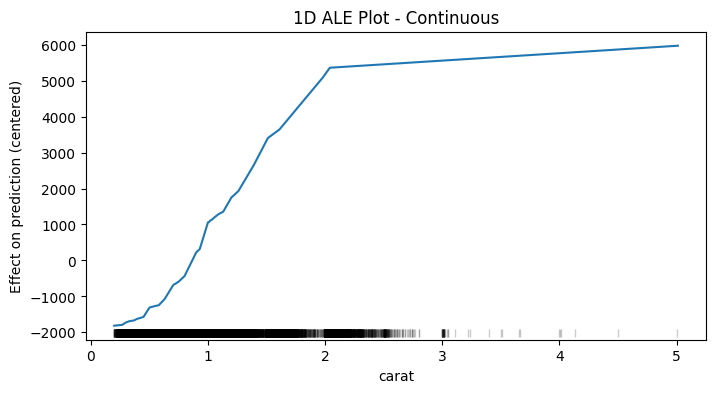

In [14]:
## 1D - continuous - no CI
ale_eff = ale(
    X=X[features], model=model, feature=["carat"], grid_size=50, include_CI=False
)

### continuous feature with confidence interval

PyALE._ALE_generic:INFO: Continuous feature detected.


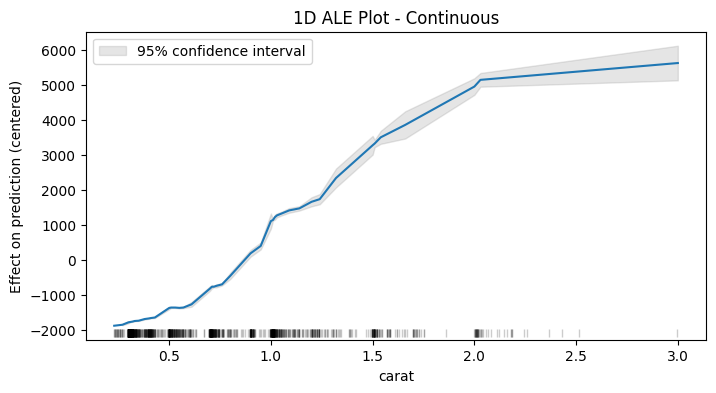

In [15]:
## 1D - continuous - with 95% CI
random.seed(123)
X_sample = X[features].loc[random.sample(X.index.to_list(), 1000), :]
ale_eff = ale(
    X=X_sample, model=model, feature=["carat"], grid_size=50, include_CI=True, C=0.95
)